<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter15/Object_detection_with_DETR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
if not os.path.exists('open-images-bus-trucks'):
    !pip install -q torch_snippets torchsummary
    !wget --quiet https://www.dropbox.com/s/agmzwk95v96ihic/open-images-bus-trucks.tar.xz
    !tar -xf open-images-bus-trucks.tar.xz
    !rm open-images-bus-trucks.tar.xz
    !git clone https://github.com/sizhky/detr/
%cd detr

     |████████████████████████████████| 36.7MB 81kB/s 
     |████████████████████████████████| 61kB 9.4MB/s 
     |████████████████████████████████| 102kB 13.4MB/s 
Cloning into 'detr'...
remote: Enumerating objects: 210, done.
remote: Total 210 (delta 0), reused 0 (delta 0), pack-reused 210
Receiving objects: 100% (210/210), 12.83 MiB | 9.59 MiB/s, done.
Resolving deltas: 100% (103/103), done.
/content/detr


In [ ]:
%cd ../open-images-bus-trucks/annotations
!cp mini_open_images_train_coco_format.json instances_train2017.json
!cp mini_open_images_val_coco_format.json instances_val2017.json
%cd ..
!ln -s images/ train2017
!ln -s images/ val2017
%cd ../detr

/content/open-images-bus-trucks/annotations
/content/open-images-bus-trucks
/content/detr


In [ ]:
CLASSES = ['', 'BUS','TRUCK']

In [ ]:
from torch_snippets import *
if not os.path.exists('detr-r50-e632da11.pth'):
    !wget https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth
    checkpoint = torch.load("detr-r50-e632da11.pth", map_location='cpu')
    del checkpoint["model"]["class_embed.weight"]
    del checkpoint["model"]["class_embed.bias"]
    torch.save(checkpoint,"detr-r50_no-class-head.pth")

--2020-10-03 05:20:31--  https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166618694 (159M) [application/octet-stream]
Saving to: ‘detr-r50-e632da11.pth’

detr-r50-e632da11.p 100%[===================>] 158.90M  11.6MB/s    in 15s     

2020-10-03 05:20:46 (10.8 MB/s) - ‘detr-r50-e632da11.pth’ saved [166618694/166618694]



In [ ]:
!python main.py --coco_path ../open-images-bus-trucks/\
  --epochs 10 --lr=1e-4 --batch_size=2 --num_workers=4\
  --output_dir="outputs" --resume="detr-r50_no-class-head.pth"

Not using distributed mode
git:
  sha: d80434914bfb9f94152f30c4b4c197953ef719e1, status: clean, branch: master

Namespace(aux_loss=True, backbone='resnet50', batch_size=2, bbox_loss_coef=5, clip_max_norm=0.1, coco_panoptic_path=None, coco_path='../open-images-bus-trucks/', dataset_file='coco', dec_layers=6, device='cuda', dice_loss_coef=1, dilation=False, dim_feedforward=2048, dist_url='env://', distributed=False, dropout=0.1, enc_layers=6, eos_coef=0.1, epochs=10, eval=False, frozen_weights=None, giou_loss_coef=2, hidden_dim=256, lr=0.0001, lr_backbone=1e-05, lr_drop=200, mask_loss_coef=1, masks=False, nheads=8, num_queries=100, num_workers=4, output_dir='outputs', position_embedding='sine', pre_norm=False, remove_difficult=False, resume='detr-r50_no-class-head.pth', seed=42, set_cost_bbox=5, set_cost_class=1, set_cost_giou=2, start_epoch=0, weight_decay=0.0001, world_size=1)
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints

In [ ]:
from main import get_args_parser, argparse, build_model
parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
args, _ = parser.parse_known_args()

model, _, _ = build_model(args)
model.load_state_dict(torch.load("outputs/checkpoint.pth")['model']);

In [ ]:
from PIL import Image, ImageDraw, ImageFont

# standard PyTorch mean-std input image normalization
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
          
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b
    
def detect(im, model, transform):
    img = transform(im).unsqueeze(0)
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'
    outputs = model(img)
    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7
    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

2020-10-03 05:38:23.562 | INFO     | torch_snippets.loader:Glob:160 - 15225 files found at ../open-images-bus-trucks/images/*


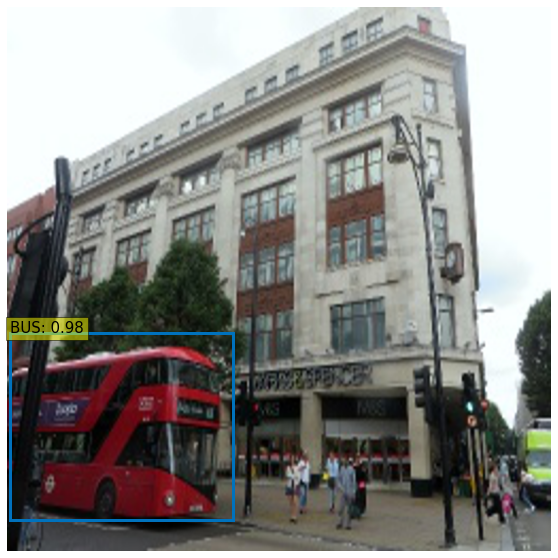

2020-10-03 05:38:26.715 | INFO     | torch_snippets.loader:Glob:160 - 15225 files found at ../open-images-bus-trucks/images/*


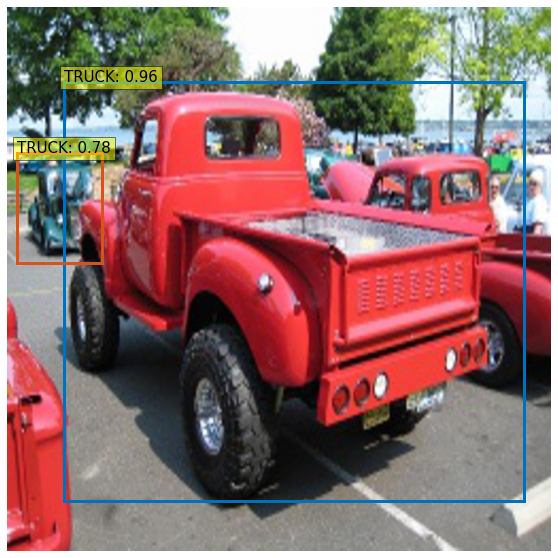

In [ ]:
for _ in range(2):
    image = Image.open(choose(Glob('../open-images-bus-trucks/images/*'))).resize((800,800)).convert('RGB')
    scores, boxes = detect(image, model, transform)
    plot_results(image, scores, boxes)